In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
# load the video
video_path = '../utah_waterlab_videos/waterlab1.mp4'

# make a video capture object
cap = cv2.VideoCapture(video_path)


In [4]:
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

In [5]:
# Read the first frame
ret, prev_frame = cap.read()
if not ret:
    print("Error: Cannot read the first frame.")
    exit()

# Convert frame to grayscale
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

In [6]:
# Prepare a list to store optical flow data
flow_data = []

# Loop over the video frames
while True:
    # Read the next frame
    ret, frame = cap.read()
    if not ret:
        break  # Exit the loop if no frame is returned

    # Convert the frame to grayscale
    curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute optical flow
    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

    # Append flow to flow_data
    flow_data.append(flow)

    # Update the previous frame
    prev_gray = curr_gray

# Release the video capture object
cap.release()

In [7]:
# Prepare input data X
X = []

for flow in flow_data:
    # Compute magnitude and angle
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=False)

    # Stack magnitude and angle into a single array
    mag_ang = np.stack((magnitude, angle), axis=-1)

    # Resize to a smaller size if necessary (to reduce computational load)
    mag_ang_resized = cv2.resize(mag_ang, (64, 64))  # Adjust size as needed

    # Append to X
    X.append(mag_ang_resized)

# Convert X to a NumPy array
X = np.array(X)

In [8]:
# Normalize data
X_max = np.max(X)
X_min = np.min(X)
X = (X - X_min) / (X_max - X_min)  # Normalize to [0, 1]

In [9]:
print("Input data shape:", X.shape)

Input data shape: (200, 64, 64, 2)


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Split data
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [14]:
input_shape = X_train.shape[1:]

# Build the autoencoder model
input_layer = keras.Input(shape=input_shape)

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same')(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = keras.Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Print model summary
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 2)      │           578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,770 (49.88 KB)

 Trainable params: 12,770 (49.88 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,  # For autoencoders, input and output are the same
    epochs=20,
    batch_size=16,
    shuffle=True,
    validation_data=(X_test, X_test)
)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1531 - val_loss: 0.1275
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1048 - val_loss: 0.0289
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0238 - val_loss: 0.0240
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0232 - val_loss: 0.0175
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0133 - val_loss: 0.0122
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.4361725e-10..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2900125e-11..1.0].


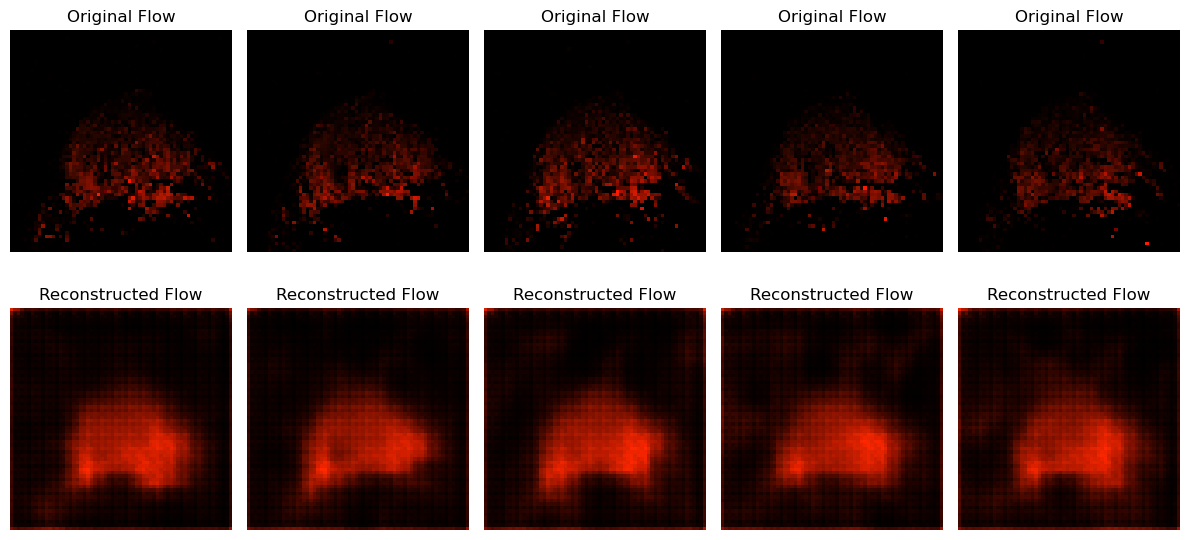

In [18]:
# Function to convert magnitude and angle to RGB
def flow_to_rgb(magnitude, angle):
    hsv = np.zeros((magnitude.shape[0], magnitude.shape[1], 3), dtype=np.float32)
    hsv[..., 0] = angle * (180 / np.pi / 2)  # Hue
    hsv[..., 1] = 1  # Saturation
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)  # Value
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

# Display original and reconstructed images
n = 5  # Number of images to display
plt.figure(figsize=(12, 6))

for i in range(n):
    # Original
    mag = X_test[i, :, :, 0]
    ang = X_test[i, :, :, 1]
    rgb = flow_to_rgb(mag, ang)
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(rgb)
    plt.title("Original Flow")
    plt.axis('off')

    # Reconstructed
    mag_rec = decoded_imgs[i, :, :, 0]
    ang_rec = decoded_imgs[i, :, :, 1]
    rgb_rec = flow_to_rgb(mag_rec, ang_rec)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(rgb_rec)
    plt.title("Reconstructed Flow")
    plt.axis('off')

plt.tight_layout()
plt.show()


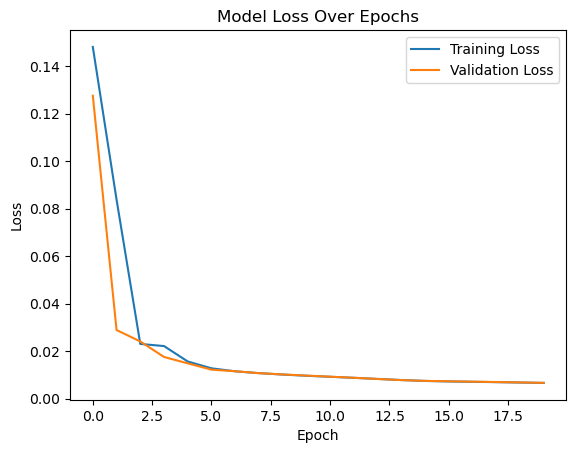

In [19]:
# Plot training and validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
# Extract the encoder part of the autoencoder
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('max_pooling2d_1').output)

# Get encoded representations of the test set
encoded_imgs = encoder.predict(X_test)
print("Encoded images shape:", encoded_imgs.shape)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Encoded images shape: (40, 16, 16, 16)


c:\Users\mehdih\AppData\Local\anaconda3\envs\water_particles\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


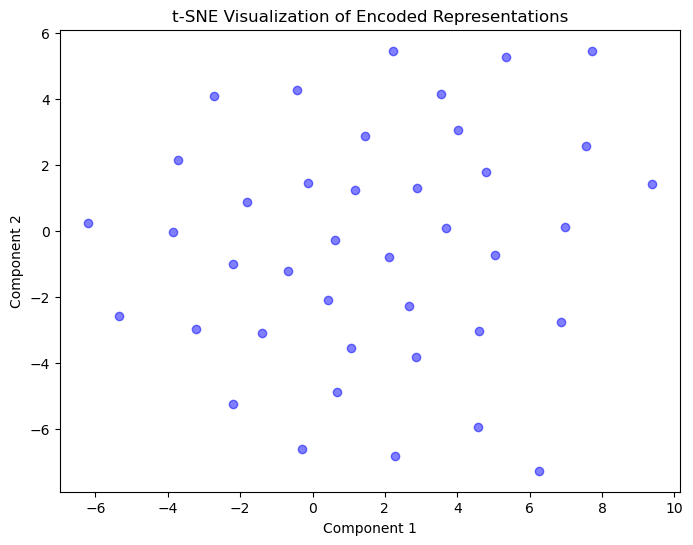

In [21]:
from sklearn.manifold import TSNE

# Flatten the encoded images
encoded_imgs_flat = encoded_imgs.reshape(encoded_imgs.shape[0], -1)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_embedded = tsne.fit_transform(encoded_imgs_flat)

# Plot the 2D t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c='blue', alpha=0.5)
plt.title('t-SNE Visualization of Encoded Representations')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [22]:
# Save the model to a file
autoencoder.save('autoencoder_model.h5')
